Samhitha Medulla - 700751257

1. Execute and save the given model and use the saved model to predict on new text data (ex, “A lot of
good things are happening. We are respected again throughout the world, and that's a great
thing .@realDonaldTrump”)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


347/347 - 37s - 106ms/step - accuracy: 0.5427 - loss: 0.9944 - val_accuracy: 0.6573 - val_loss: 0.8280
Epoch 2/10
347/347 - 33s - 96ms/step - accuracy: 0.6463 - loss: 0.8052 - val_accuracy: 0.6645 - val_loss: 0.7942
Epoch 3/10
347/347 - 42s - 120ms/step - accuracy: 0.6824 - loss: 0.7180 - val_accuracy: 0.6569 - val_loss: 0.8338
Epoch 4/10
347/347 - 40s - 114ms/step - accuracy: 0.6994 - loss: 0.6639 - val_accuracy: 0.6649 - val_loss: 0.8191


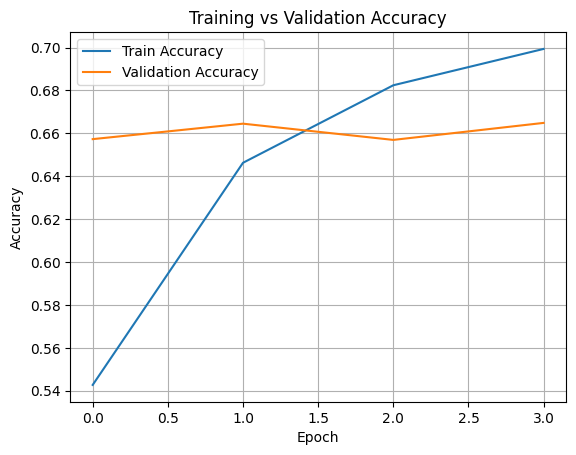

In [7]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Load and clean data
data = pd.read_csv('Data.csv')
data = data[['text', 'sentiment']]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'] = data['text'].apply(lambda x: x.replace('rt', ' '))

# Tokenization
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['sentiment'])
y = to_categorical(integer_encoded)

# Class weight handling
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(integer_encoded),
    y=integer_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Model creation
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with validation and early stopping
history = model.fit(X, y,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=[early_stop],
                    class_weight=class_weights_dict)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save model and tools
model.save("sentiment_model.h5")
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('labelencoder.pkl', 'wb') as f:
    pickle.dump(labelencoder, f)


In [8]:
# predict_sentiment.py

import re
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load saved model, tokenizer, and labelencoder
model = load_model('sentiment_model.h5')
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('labelencoder.pkl', 'rb') as f:
    labelencoder = pickle.load(f)

# Input text to predict
new_text = "A lot of good things are happening. We are respected again throughout the world, and that's a great thing .@realDonaldTrump"
new_text = re.sub('[^a-zA-z0-9\s]', '', new_text.lower()).replace('rt', ' ')
seq = tokenizer.texts_to_sequences([new_text])
padded = pad_sequences(seq, maxlen=model.input_shape[1])  # Match input length

# Predict sentiment
pred = model.predict(padded)
predicted_label = np.argmax(pred, axis=1)
sentiment = labelencoder.inverse_transform(predicted_label)

# Print result
print("Predicted Sentiment:", sentiment[0])
print("Prediction Probabilities:", pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Predicted Sentiment: Positive
Prediction Probabilities: [[0.32852995 0.08683427 0.5846358 ]]


2. Apply GridSearchCV on the source code provided and produce the results with the best combination.

In [18]:
import pandas as pd
import numpy as np
import re
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load and preprocess a smaller dataset for speed
data = pd.read_csv("Data.csv")
data = data[['text', 'sentiment']]
data = data.sample(frac=0.2, random_state=42)  # Only 20% for quick grid search
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x.lower()).replace('rt', ''))

# Tokenize text
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

# Encode labels
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(data['sentiment'])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Minimal grid for quick execution
param_grid = {
    'embed_dim': [64],
    'lstm_out': [128, 196],
    'batch_size': [32],
    'epochs': [2]
}

results = []

# Run manual grid search
for embed_dim in param_grid['embed_dim']:
    for lstm_out in param_grid['lstm_out']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                print(f"\n Training with embed_dim={embed_dim}, lstm_out={lstm_out}, batch_size={batch_size}, epochs={epochs}")
                model = Sequential()
                model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
                model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
                model.add(Dense(3, activation='softmax'))
                model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

                start_time = time.time()
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))
                elapsed = time.time() - start_time

                val_acc = history.history['val_accuracy'][-1]
                val_loss = history.history['val_loss'][-1]

                print(f"val_acc={val_acc:.4f}, val_loss={val_loss:.4f}, time={elapsed:.1f}s")

                results.append({
                    'embed_dim': embed_dim,
                    'lstm_out': lstm_out,
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'val_accuracy': val_acc,
                    'val_loss': val_loss,
                    'time_sec': elapsed
                })

# Display results
results_df = pd.DataFrame(results)
best = results_df.sort_values(by='val_accuracy', ascending=False).head(1)

print("\n Best configuration:")
print(best)

# Optionally save to CSV
results_df.to_csv("quick_grid_results.csv", index=False)



 Training with embed_dim=64, lstm_out=128, batch_size=32, epochs=2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


val_acc=0.6547, val_loss=0.7630, time=19.8s

 Training with embed_dim=64, lstm_out=196, batch_size=32, epochs=2
val_acc=0.6475, val_loss=0.7660, time=12.5s

 Best configuration:
   embed_dim  lstm_out  batch_size  epochs  val_accuracy  val_loss   time_sec
0         64       128          32       2      0.654676  0.762977  19.807572
